In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import SGD
from keras.wrappers.scikit_learn import KerasClassifier


from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import xgboost as xgb

In [ ]:
pd.options.display.max_columns=1000
pd.options.display.max_rows=1000

In [ ]:
path='drive/My Drive/Datasets/CNC/'
train=pd.read_csv(path+'train.csv')

In [ ]:
df_all=pd.DataFrame()

for i in range(1,19):
  if i<10:
    ex='0'+str(i)
  else:
    ex=str(i)
  experiment=pd.read_csv(path+"experiment_{}.csv".format(ex))
  experiment['No']=i
  df_all=pd.concat([df_all,experiment])

In [ ]:
df_all.shape

(25286, 49)

In [ ]:
df_all=pd.merge(df_all, train, on='No', how='left')
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25286 entries, 0 to 25285
Data columns (total 55 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   X1_ActualPosition          25286 non-null  float64
 1   X1_ActualVelocity          25286 non-null  float64
 2   X1_ActualAcceleration      25286 non-null  float64
 3   X1_CommandPosition         25286 non-null  float64
 4   X1_CommandVelocity         25286 non-null  float64
 5   X1_CommandAcceleration     25286 non-null  float64
 6   X1_CurrentFeedback         25286 non-null  float64
 7   X1_DCBusVoltage            25286 non-null  float64
 8   X1_OutputCurrent           25286 non-null  float64
 9   X1_OutputVoltage           25286 non-null  float64
 10  X1_OutputPower             25286 non-null  float64
 11  Y1_ActualPosition          25286 non-null  float64
 12  Y1_ActualVelocity          25286 non-null  float64
 13  Y1_ActualAcceleration      25286 non-null  flo

In [ ]:
def handle_non_numerical_data(df): 
    columns = df.columns

    for column in columns:
        text_digit_vals = {}
        def convert_to_int(val):
            return text_digit_vals[val]

        if df[column].dtype != np.int64 and df[column].dtype != np.float64:
            column_contents = df[column].values.tolist()
            unique_elements = set(column_contents)
            x = 0
            for unique in unique_elements:
                if unique not in text_digit_vals:
                    text_digit_vals[unique] = x
                    x+=1

            df[column] = list(map(convert_to_int, df[column]))

    return df

df_all=handle_non_numerical_data(df_all)

In [ ]:
df_all.head()

,X1_ActualPosition,X1_ActualVelocity,X1_ActualAcceleration,X1_CommandPosition,X1_CommandVelocity,X1_CommandAcceleration,X1_CurrentFeedback,X1_DCBusVoltage,X1_OutputCurrent,X1_OutputVoltage,X1_OutputPower,Y1_ActualPosition,Y1_ActualVelocity,Y1_ActualAcceleration,Y1_CommandPosition,Y1_CommandVelocity,Y1_CommandAcceleration,Y1_CurrentFeedback,Y1_DCBusVoltage,Y1_OutputCurrent,Y1_OutputVoltage,Y1_OutputPower,Z1_ActualPosition,Z1_ActualVelocity,Z1_ActualAcceleration,Z1_CommandPosition,Z1_CommandVelocity,Z1_CommandAcceleration,Z1_CurrentFeedback,Z1_DCBusVoltage,Z1_OutputCurrent,Z1_OutputVoltage,S1_ActualPosition,S1_ActualVelocity,S1_ActualAcceleration,S1_CommandPosition,S1_CommandVelocity,S1_CommandAcceleration,S1_CurrentFeedback,S1_DCBusVoltage,S1_OutputCurrent,S1_OutputVoltage,S1_OutputPower,S1_SystemInertia,M1_CURRENT_PROGRAM_NUMBER,M1_sequence_number,M1_CURRENT_FEEDRATE,Machining_Process,No,material,feedrate,clamp_pressure,tool_condition,machining_finalized,passed_visual_inspection
0,198.0,0.0,0.00,198.0,0.0,0.000000,0.18,0.0207,329.0,2.77,-0.000001,158.0,-0.025,-6.25,158.0,0.0,0.000000,0.539,0.0167,328.0,1.84,6.430000e-07,119.0,0.0,0.00,119.0,0.0,0.000000,0.0,0.0,0.0,0.0,-361.0,0.001,0.250,-361.0,0.0,0.0,0.524,2.740000e-19,329.0,0.0,6.960000e-07,12.0,1.0,0.0,50.0,8,1,0,6,4.0,1,1,2
1,198.0,-10.8,-350.00,198.0,-13.6,-358.000000,-10.90,0.1860,328.0,23.30,0.004480,158.0,-19.800,-750.00,157.0,-24.6,-647.000000,-14.500,0.2810,325.0,37.80,1.260000e-02,119.0,-20.3,-712.00,118.0,-25.6,-674.000000,0.0,0.0,0.0,0.0,-361.0,0.000,0.250,-361.0,0.0,0.0,-0.288,2.740000e-19,328.0,0.0,-5.270000e-07,12.0,1.0,4.0,50.0,9,1,0,6,4.0,1,1,2
2,196.0,-17.8,-6.25,196.0,-17.9,-0.000095,-8.59,0.1400,328.0,30.60,0.005330,154.0,-32.500,0.00,154.0,-32.3,-0.000095,-7.790,0.1390,327.0,49.40,9.430000e-03,115.0,-33.7,37.50,115.0,-33.7,-0.000095,0.0,0.0,0.0,0.0,-361.0,0.000,-0.438,-361.0,0.0,0.0,0.524,2.740000e-19,328.0,0.0,9.100000e-07,12.0,1.0,7.0,50.0,9,1,0,6,4.0,1,1,2
3,194.0,-18.0,0.00,194.0,-17.9,-0.000095,-6.11,0.1300,327.0,30.30,0.004890,151.0,-32.600,-62.50,151.0,-32.3,-0.000095,-8.130,0.1560,325.0,47.60,1.050000e-02,112.0,-33.7,-6.25,112.0,-33.7,0.000000,0.0,0.0,0.0,0.0,-361.0,-0.001,-0.250,-361.0,0.0,0.0,-0.180,2.740000e-19,328.0,0.0,1.070000e-06,12.0,1.0,7.0,50.0,9,1,0,6,4.0,1,1,2
4,193.0,-17.9,-18.80,192.0,-17.9,0.000095,-5.70,0.1140,328.0,30.50,0.004250,148.0,-32.000,138.00,148.0,-32.3,0.000095,-13.800,0.2020,326.0,47.10,1.350000e-02,109.0,-33.6,18.80,108.0,-33.7,0.000000,0.0,0.0,0.0,0.0,-361.0,0.000,-0.188,-361.0,0.0,0.0,0.226,2.740000e-19,328.0,0.0,1.960000e-06,12.0,1.0,7.0,50.0,9,1,0,6,4.0,1,1,2


In [ ]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25286 entries, 0 to 25285
Data columns (total 55 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   X1_ActualPosition          25286 non-null  float64
 1   X1_ActualVelocity          25286 non-null  float64
 2   X1_ActualAcceleration      25286 non-null  float64
 3   X1_CommandPosition         25286 non-null  float64
 4   X1_CommandVelocity         25286 non-null  float64
 5   X1_CommandAcceleration     25286 non-null  float64
 6   X1_CurrentFeedback         25286 non-null  float64
 7   X1_DCBusVoltage            25286 non-null  float64
 8   X1_OutputCurrent           25286 non-null  float64
 9   X1_OutputVoltage           25286 non-null  float64
 10  X1_OutputPower             25286 non-null  float64
 11  Y1_ActualPosition          25286 non-null  float64
 12  Y1_ActualVelocity          25286 non-null  float64
 13  Y1_ActualAcceleration      25286 non-null  flo

In [ ]:
df_all['tool_condition'].value_counts(normalize=True)

0    0.526299
1    0.473701
Name: tool_condition, dtype: float64

In [ ]:
col=df_all.corrwith(df_all['tool_condition'])
col.reset_index()

,index,0
0,X1_ActualPosition,0.091920
1,X1_ActualVelocity,0.008353
2,X1_ActualAcceleration,-0.004147
3,X1_CommandPosition,0.092029
4,X1_CommandVelocity,0.008909
5,X1_CommandAcceleration,0.005586
6,X1_CurrentFeedback,0.020931
7,X1_DCBusVoltage,-0.076864
8,X1_OutputCurrent,0.080973
9,X1_OutputVoltage,-0.075167


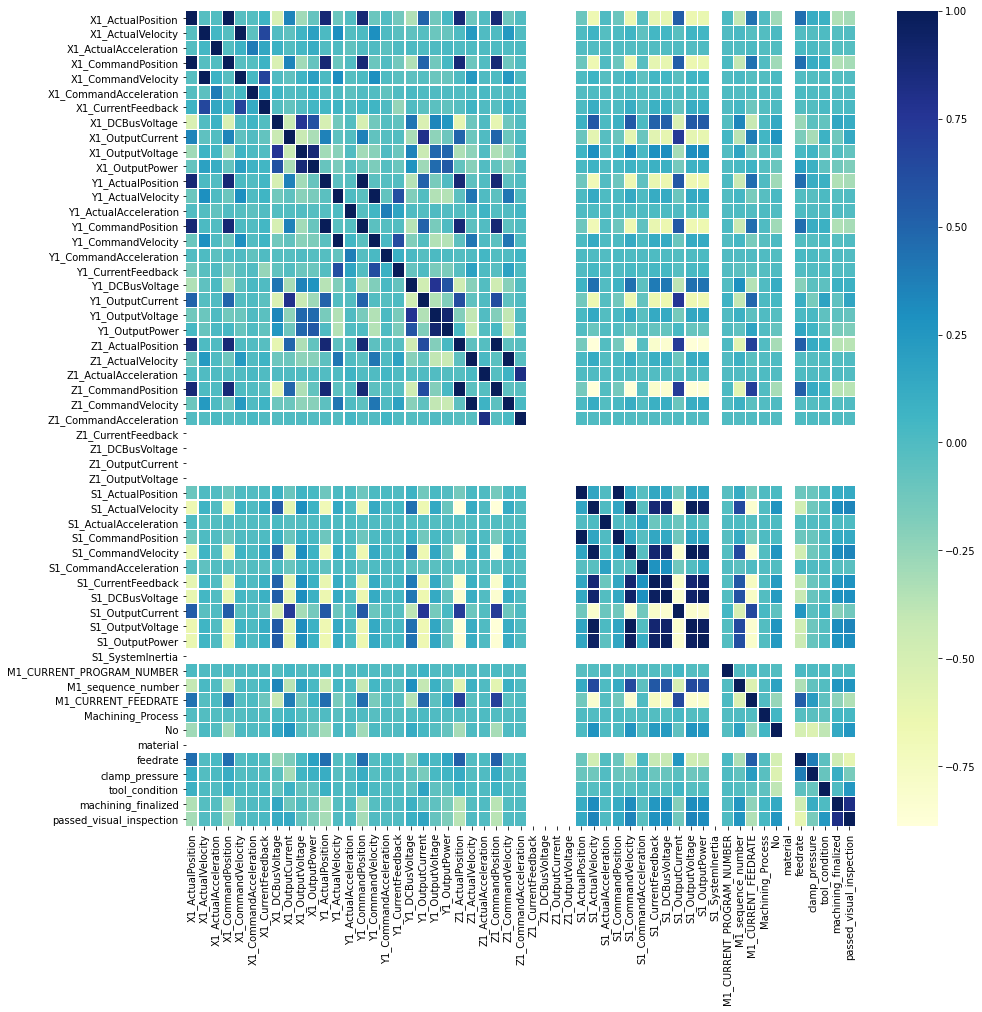

In [ ]:
plt.figure(figsize=(15,15))
corr_matrix=df_all.corr()
sns.heatmap(data=corr_matrix, cmap='YlGnBu',annot=False,linewidths=.2)

In [ ]:
def correlation(dataset, threshold):
  col_corr=set()
  corr_mat=dataset.corr()
  for i in range(len(corr_mat.columns)):
    for j in range(i):
      if abs(corr_mat.iloc[i,j]) > threshold:
        colname=corr_mat.columns[i]
        col_corr.add(colname)
  return col_corr
high_corr=correlation(df_all,0.4)
print(high_corr)
#print(df_all.corrwith(df_all['tool_condition']))

{'Y1_CurrentFeedback', 'M1_CURRENT_FEEDRATE', 'S1_OutputVoltage', 'M1_sequence_number', 'S1_CommandVelocity', 'X1_OutputCurrent', 'S1_CurrentFeedback', 'X1_CommandVelocity', 'clamp_pressure', 'passed_visual_inspection', 'X1_DCBusVoltage', 'feedrate', 'Y1_CommandPosition', 'X1_CurrentFeedback', 'Y1_DCBusVoltage', 'Y1_ActualPosition', 'machining_finalized', 'Y1_OutputPower', 'X1_CommandPosition', 'S1_DCBusVoltage', 'S1_OutputPower', 'Z1_CommandAcceleration', 'X1_OutputPower', 'S1_OutputCurrent', 'Z1_CommandPosition', 'Y1_CommandVelocity', 'Z1_ActualPosition', 'Z1_ActualVelocity', 'X1_OutputVoltage', 'S1_ActualVelocity', 'S1_CommandPosition', 'Y1_OutputVoltage', 'Y1_OutputCurrent', 'Z1_CommandVelocity'}


In [ ]:
input_features = ['S1_OutputCurrent', 'X1_OutputCurrent','Y1_OutputCurrent',
                  'X1_DCBusVoltage', 'Y1_DCBusVoltage', 'S1_DCBusVoltage',
                  'S1_CurrentFeedback', 'X1_CurrentFeedback',
                  'X1_OutputVoltage', 'Y1_OutputVoltage',
                  'X1_OutputPower', 'Y1_OutputPower', 
                  'M1_CURRENT_FEEDRATE',
                  'X1_ActualVelocity','Y1_ActualVelocity','Z1_ActualVelocity','S1_ActualVelocity',
                  'X1_ActualAcceleration','S1_ActualAcceleration',
                  'S1_OutputPower', 'S1_OutputVoltage']
                     ##'X1_ActualPosition', 'Y1_ActualPosition', 'Z1_ActualPosition',

In [ ]:
user_input=['X1_ActualVelocity','Y1_ActualVelocity','Z1_ActualVelocity','S1_ActualVelocity',
            'X1_OutputCurrent', 'Y1_OutputCurrent', 'S1_OutputCurrent',
            'X1_DCBusVoltage', 'Y1_DCBusVoltage','S1_DCBusVoltage',
            'X1_CurrentFeedback','S1_CurrentFeedback',
            'X1_OutputVoltage', 'Y1_OutputVoltage',
            'X1_OutputPower', 'Y1_OutputPower',
            'feedrate','M1_CURRENT_FEEDRATE','clamp_pressure']

In [ ]:
#high_corr.remove('passed_visual_inspection')
#high_corr.remove('machining_finalized')
X=df_all[high_corr]
Y=df_all['tool_condition']

In [ ]:
print(X.shape)
print(Y.shape)

(25286, 34)
(25286,)


In [ ]:
X=X.values.astype(float)
Y=Y.values.astype(float)

In [ ]:
X.shape

(25286, 34)


>>![alt text](https://www.dspguide.com/graphics/F_26_5.gif)

In [ ]:
def baseline():
  model=Sequential()
  model.add(Dense(34,input_dim=34,activation='relu'))
  model.add(Dense(17,activation='relu'))
  model.add(Dense(9,activation='relu'))
  model.add(Dropout(0.1))
  model.add(Dense(1,activation='sigmoid'))
  #opt = SGD(lr=0.01)
  model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
  return model

In [ ]:
estimator=[]
estimator.append(('Standardize', StandardScaler()))
estimator.append(('nn',KerasClassifier(baseline,epochs=300,batch_size=25,verbose=0)))
pipeline=Pipeline(estimator)

In [ ]:
kfold=StratifiedKFold(n_splits=5,shuffle=True,random_state=100)
results=cross_val_score(pipeline, X, Y, cv=kfold)
print(pipeline)
print("Baseline: %.2f%%  (%.2f%%)"% (results.mean()*100, results.std()*100))

In [ ]:
scaler=StandardScaler()
scaled_x=scaler.fit_transform(X)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(scaled_x, Y, test_size=0.20, random_state=101)

In [ ]:
X_train.shape

(20228, 34)

In [ ]:
model=baseline()
history=model.fit(X_train,y_train,epochs=1000,batch_size=20)

Epoch 1/1000
20228/20228 [==============================] - 2s 74us/step - loss: 0.5656 - accuracy: 0.6555
Epoch 2/1000
20228/20228 [==============================] - 1s 70us/step - loss: 0.4481 - accuracy: 0.7439
Epoch 3/1000
20228/20228 [==============================] - 1s 71us/step - loss: 0.4081 - accuracy: 0.7755
Epoch 4/1000
20228/20228 [==============================] - 1s 69us/step - loss: 0.3803 - accuracy: 0.7963
Epoch 5/1000
20228/20228 [==============================] - 1s 69us/step - loss: 0.3577 - accuracy: 0.8117
Epoch 6/1000
20228/20228 [==============================] - 1s 68us/step - loss: 0.3388 - accuracy: 0.8223
Epoch 7/1000
20228/20228 [==============================] - 1s 70us/step - loss: 0.3267 - accuracy: 0.8335
Epoch 8/1000
20228/20228 [==============================] - 2s 76us/step - loss: 0.3151 - accuracy: 0.8395
Epoch 9/1000
20228/20228 [==============================] - 1s 69us/step - loss: 0.3048 - accuracy: 0.8428
Epoch 10/1000
20228/20228 [==========

In [ ]:
pip install ann_visualizer

  Created wheel for ann-visualizer: filename=ann_visualizer-2.5-cp36-none-any.whl size=4169 sha256=ea3c4a1fb91f58a343054a53f793fb1e9ac562fc33eea0758dfa77e737d00c3a
  Stored in directory: /root/.cache/pip/wheels/b6/b4/4e/d92f50c9c4f004cf315a0e0fcd455486bd799c50fe80cf1f5d
Successfully built ann-visualizer


In [ ]:
pip install graphviz

In [ ]:
from ann_visualizer.visualize import ann_viz

ann_viz(model, view=True, filename='network.gv', title="Artificial Neural Network Visualization")

In [ ]:
plt.show()

In [ ]:
scores = model.evaluate(X_test, y_test, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]))
print("%s: %.2f%%" % (model.metrics_names[0], scores[0]))

accuracy: 0.93%
loss: 0.43%


In [ ]:
y_test

array([0., 1., 0., ..., 1., 0., 0.])

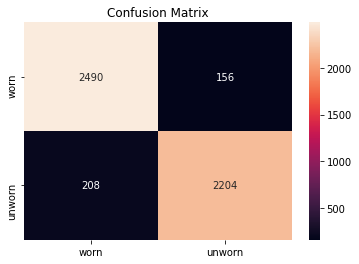

In [ ]:
import seaborn as sns
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
prediction= model.predict_classes(X_test)
prediction

conf=confusion_matrix(y_test, prediction)
sns.heatmap(conf,annot=True,fmt="0000.0f",xticklabels=["worn","unworn"],yticklabels=['worn','unworn'])
plt.title('Confusion Matrix')
plt.show()


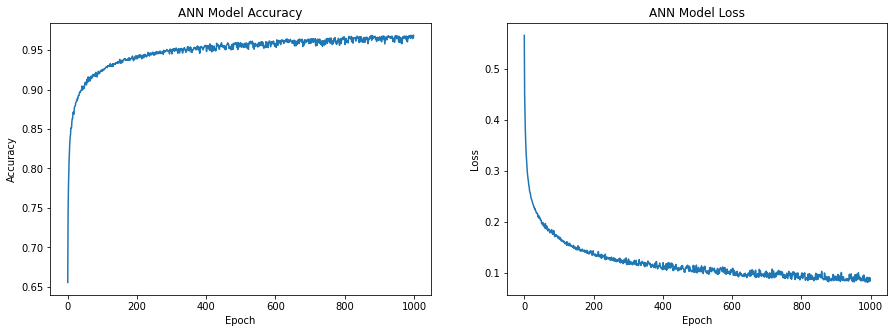

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.title('ANN Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.title('ANN Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [ ]:
lyst = list(map(float,input("\nEnter the numbers : ").strip().split()))[:14]

In [ ]:
lyst_1= np.array(lyst)

In [ ]:
lyst_1= lyst_1.reshape(1, 34)

In [ ]:
lyst_1.shape

In [ ]:
lyst_1

In [ ]:
model.predict_classes(lyst_1)

In [ ]:
model.__doc__

In [ ]:
X_test.shape